For the first post, I thought I would do a simple demonstration of a naive risk parity portfolio. Naive risk parity is a very simple approach to diversification: it simply weights assets according to the inverse of their volatility. Highly volatile assets have a lower weight and low volatility assets have a higher weight. However, this simplicity is quite powerful and its risk-adjusted performance is superior to more complex approaches. This is likely because it is less prone to model risk and parameter instability than other methods, like mean-variance optimization.

We first import our packages.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

## Getting the Data
We'll use pandas datareader for this feature. We also import datetime to work with the dates feature of pandas datareader.

In [4]:
import pandas_datareader
from pandas_datareader.data import DataReader
import datetime
from datetime import date

We set an arbitrary start date as January 1, 2009. We use four ETFs to proxy the four main asset classes used in risk parity strategies. <br>

1) ACWI for Global Equities <br>
2) IEF for Nominal Treasuries (Intermediate Term) <br>
3) TIP for Treasury Inflation Protected Securities (TIPS Intermediate Term) <br>
4) DBC for Commodities <br>

There are a host of nuances here that are beyond the scope of this post. Suffice it to say, there is much to nitpick here and ideally we would be maybe even split out sub asset classes, sectors, maturity structures etc. We'll get into the limitations and important assumptions later in the post.

In [5]:
start = date(2009, 1, 1) # set start date
tickers = ['ACWI', 'IEF','TIP','DBC'] # set list of tickers
data_source = 'google' # set datasource for pandas datareader

etf_data = DataReader(tickers, data_source, start) #import data from google finance
etf_data = etf_data.to_frame() #change from panel to dataframe
etf_data = etf_data['Close'].unstack() # unstack into columns

## Transforming the Data
To build a naive risk parity portfolio we need measure the volatility of each asset.The standard for a naive risk parity strategy is the trailing one-year standard deviation as a proxy for volatility. 

To compute this: <br>
1) We first transform our data from price data to return data. We calculate daily returns using the .pct_change() <br>

2) There are a few gaps in the data so we use .ffill() to fill these in otherwise the rolling feature we use next will not know how to handle the N/A values. <br>

3) We compute the standard deviation across rolling one-year (252 trading days) windows. We annualize the standard deviation by multiplying by the square root of one-year. <br>

In [6]:
returns = etf_data.pct_change(1) # calculated daily returns using pct_change
returns = returns.ffill() # ffill to fill in a few  gaps, otherwise .std() will produce NaN
std = returns.rolling(window=252, center=False).std()*np.sqrt(252) #trailing 252-day daily standard deviation, annualized

## Building the Portfolios

Now that we have our volatility data we can construct the portfolio. <br>

1) We need the inverses of the standard deviations to calculate the denominator in our weighting scheme.<br>
2) We sum the inverses of the standard deviation, adding a Total column. <br>
3) For each date, we divide the inverse of each asset's standard deviation by the sum of all the assets' inverse standard deviation.

In [7]:
inv = 1/std  # take the inverse of each datapoint
inv['Total'] = np.sum(inv, axis=1) # create a total column and sum across each row (date) of the inverse data 
weights = inv.div(inv['Total'], axis=0)
weights= weights.drop('Total', axis=1)
weights = weights.dropna()

Now let's plot the output. As you would imagine, assets with lower volatility, nominal government bonds and TIPs, have higher weights and more volatile assets have lower weights. Now an investor could just lever this portfolio up or down to a volatility or return target.

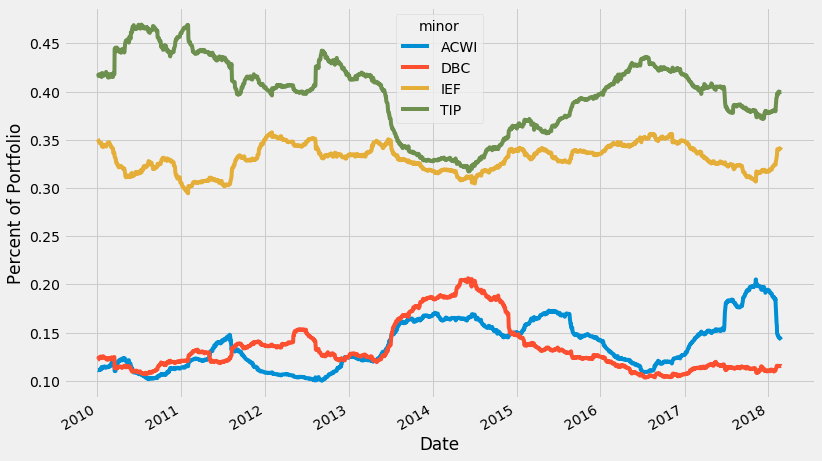

In [8]:
weights.plot(figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('Percent of Portfolio')
plt.show()

# Challenges & Assumptions
Now, let's discuss some of the challenges/assumptions with a naive risk parity strategy:

#### 1. Asset class selection<br>
Asset class selection is critical for naive risk parity because the strategy does not incorporate correlations. So, if you tried to build a portfolio with highly correlated assets, like a portfolio of 10 US large cap equities then you're still basically taking equity beta risk. Sure the weightings will be cute but it's still equity beta. So the allocator either must have some quantitative standard or exercise some judgement about assets to include. I only mention this because this problem with asset class selection is still present in more robust versions of risk parity.

#### 2. Short correlation bet<br>
The "naivete" in naive risk parity is the assumption about asset correlations--that they are all zero. This is empirically not true. So why do it? If an investor feels that correlations are unstable or that they cannot be reliably estimated (for which there is compelling evidence) then they may choose to not be naive by including them. However, this amounts to a massive short correlation bet. If correlations among assets rise as they are wont to do during periods of market stress, then this strategy suffers for it. That said, even more robust versions of risk parity still make this bet, albeit in a different manner.

#### 3. Sharpe Ratios<br>
There is also an implicit assumption that all assets will exhibit similar excess returns per unit of risk. They will all have similar Sharpe ratios. Again, there is strong evidence that this is not the case (or that we should even be considering Sharpe ratios as an appropriate measure). However, this may be true in an abstract sense for firm believers in market efficiency. The volatility measure used in Sharpe ratios is hardly comprehensive. So assets that may appear to have abnormally high or low Sharpe ratios may simply be hiding their risk in some other component of their distribution.


## Further Reading
If you want to dig a little deeper into risk parity, see the links below. GestaltU has a whole blog post series on the topic which is well worth the time.

http://www.gestaltu.com/2013/10/dynamic-asset-allocation-for-practitioners-part-4-naive-risk-parity.html/
http://www.nam.natixis.com/Content/Documents/Publications/Research%20paper/ICS/ResearchPaper_RiskParity_EN.pdf